# 3. Leaky Aquifer Test - Texas Hill Example
**This example is taken from AQTESOLV examples.**

### Import packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import ttim as ttm

plt.rcParams["figure.figsize"] = [5, 3]

## Introduction and Conceptual Model

This pumping test, taken from the AQTESOLV examples, was done in the location of 'Texas Hill'. A pumping well was screened at an aquifer located between 20 ft and 70 ft depths. The aquifer is overlain by an aquitard. The formation at the base of the aquifer is considered an aquiclude.

Three observation wells are located at 40, 80 160 ft distance. They are denominated OW1, OW2 and OW3, respectively. Pumping lasted for 420 minutes at a rate of 4488 gallons per minute. The hydrogeological conceptual model can be seen in the figure below.

In this example, we will reproduce the work of Xinzhu (2020). We compare the aquifer test results using Hantush's solution (Hantush 1955) in the software AQTESOLV (Duffield, 2007) and TTim. We also explore the capabilities of TTim to account for aquitard storage and wellbore effects such as wellbore storage and skin effect, which cannot be simulated with Hantush's solution.

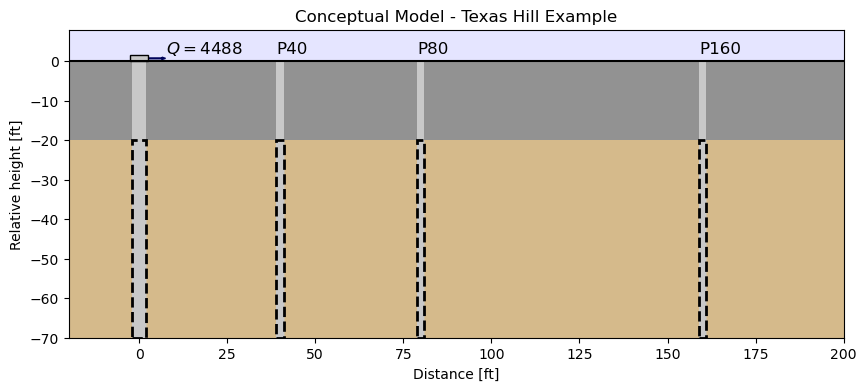

In [2]:
# Conceptual Model 1
import matplotlib.pyplot as plt

##Now printing the conceptual model figure:

fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(1, 1, 1)
# sky
sky = plt.Rectangle((-20, 0), width=220, height=8, fc="b", zorder=0, alpha=0.1)
ax.add_patch(sky)

# Aquifer:
ground = plt.Rectangle(
    (-20, -70),
    width=220,
    height=50,
    fc=np.array([209, 179, 127]) / 255,
    zorder=0,
    alpha=0.9,
)
ax.add_patch(ground)

# Confining bed:
confining_unit = plt.Rectangle(
    (-20, -20),
    width=220,
    height=20,
    fc=np.array([100, 100, 100]) / 255,
    zorder=0,
    alpha=0.7,
)
ax.add_patch(confining_unit)

well = plt.Rectangle(
    (-2, -70), width=4, height=70, fc=np.array([200, 200, 200]) / 255, zorder=1
)
ax.add_patch(well)

# Wellhead
wellhead = plt.Rectangle(
    (-2.5, 0), width=5, height=1.5, fc=np.array([200, 200, 200]) / 255, zorder=2, ec="k"
)
ax.add_patch(wellhead)

# Screen for the well:
screen = plt.Rectangle(
    (-2, -70),
    width=4,
    height=50,
    fc=np.array([200, 200, 200]) / 255,
    alpha=1,
    zorder=2,
    ec="k",
    ls="--",
)
screen.set_linewidth(2)
ax.add_patch(screen)
pumping_arrow = plt.Arrow(x=2.5, y=0.75, dx=5, dy=0, color="#00035b")
ax.add_patch(pumping_arrow)
ax.text(x=7.5, y=2, s=r"$ Q = 4488$", fontsize="large")
# Piezometers
piez1 = plt.Rectangle(
    (39, -70), width=2, height=70, fc=np.array([200, 200, 200]) / 255, zorder=1
)
screen_piez_1 = plt.Rectangle(
    (39, -70),
    width=2,
    height=50,
    fc=np.array([200, 200, 200]) / 255,
    alpha=1,
    zorder=2,
    ec="k",
    ls="--",
)
screen_piez_1.set_linewidth(2)

piez2 = plt.Rectangle(
    (79, -70), width=2, height=70, fc=np.array([200, 200, 200]) / 255, zorder=1
)
screen_piez_2 = plt.Rectangle(
    (79, -70),
    width=2,
    height=50,
    fc=np.array([200, 200, 200]) / 255,
    alpha=1,
    zorder=2,
    ec="k",
    ls="--",
)
screen_piez_2.set_linewidth(2)

piez3 = plt.Rectangle(
    (159, -70), width=2, height=70, fc=np.array([200, 200, 200]) / 255, zorder=1
)
screen_piez_3 = plt.Rectangle(
    (159, -70),
    width=2,
    height=50,
    fc=np.array([200, 200, 200]) / 255,
    alpha=1,
    zorder=2,
    ec="k",
    ls="--",
)
screen_piez_3.set_linewidth(2)


ax.add_patch(piez1)
ax.add_patch(screen_piez_1)
ax.add_patch(piez2)
ax.add_patch(screen_piez_2)
ax.add_patch(piez3)
ax.add_patch(screen_piez_3)

# last line
line = plt.Line2D(xdata=[-200, 1200], ydata=[0, 0], color="k")
ax.add_line(line)

ax.text(x=39, y=2, s="P40", fontsize="large")
ax.text(x=79, y=2, s="P80", fontsize="large")
ax.text(x=159, y=2, s="P160", fontsize="large")


ax.set_xlim([-20, 200])
ax.set_ylim([-70, 8])
ax.set_xlabel("Distance [ft]")
ax.set_ylabel("Relative height [ft]")
ax.set_title("Conceptual Model - Texas Hill Example");

### Set basic parameters

Here we have previously converted the values to ***meters*** and ***days***.

In [3]:
Q = 24464.06  # constant discharge, m^3/d
b1 = 6.096  # overlying aquitard thickness, m
b2 = 15.24  # aquifer thickness, m
zt = -b1  # top boundary of aquifer, m
zb = -b1 - b2  # bottom boundary of aquifer, m
rw = 0.1524  # well radius, m

### Load dataset of observation wells

Each observation well is located in a text file, where the first column is time data in days and the second column is drawdown in meters.
We also declare the distance of each observation to the wells: (```r1```:```r3```)

In [4]:
data1 = np.loadtxt("data/texas40.txt")
t1 = data1[:, 0]
h1 = data1[:, 1]
r1 = 12.191  # distance between obs1 to pumping well in m

data2 = np.loadtxt("data/texas80.txt")
t2 = data2[:, 0]
h2 = data2[:, 1]
r2 = 24.383  # distance between obs2 to pumping well in m

data3 = np.loadtxt("data/texas160.txt")
t3 = data3[:, 0]
h3 = data3[:, 1]
r3 = 48.766  # distance between obs3 to pumping well in m

### Create a conceptual model

We define a `ModelMaq` model for the semi-confined aquifer using the methods described in previous notebooks.
In this initial model, we will model the overlying layer as an aquitard with storage (```Sll```, the storage parameter, is defined in ModelMaq).

In [5]:
ml_0 = ttm.ModelMaq(
    kaq=10,
    z=[0, zt, zb],
    Saq=0.001,
    Sll=0,
    c=10,
    tmin=0.001,
    tmax=1,
    topboundary="semi",
)
w_0 = ttm.Well(ml_0, xw=0, yw=0, rw=rw, tsandQ=[(0, Q)], layers=0)
ml_0.solve()

self.neq  1
solution complete


### Model Calibration

Using all three observation wells, we calibrate for the hydraulic parameters of the aquifer (```kaq``` and ```Saq```) and for the aquitard (```c``` and ```Sll```).

In [6]:
# unknown parameters: kaq, Saq, c, Sll
ca_0 = ttm.Calibrate(ml_0)
ca_0.set_parameter(name="kaq0", initial=10)
ca_0.set_parameter(name="Saq0", initial=1e-4)
ca_0.set_parameter(name="Sll0", initial=1e-4, pmin=0)
ca_0.set_parameter(name="c0", initial=100)
ca_0.series(name="OW1", x=r1, y=0, t=t1, h=h1, layer=0)
ca_0.series(name="OW2", x=r2, y=0, t=t2, h=h2, layer=0)
ca_0.series(name="OW3", x=r3, y=0, t=t3, h=h3, layer=0)
ca_0.fit()

.................................................................................................................................................................................................
Fit succeeded.


In [7]:
display(ca_0.parameters.loc[:, ["optimal"]])
print("RMSE:", ca_0.rmse())

,optimal
kaq0,2.244897e+02
Saq0,2.136000e-04
Sll0,1.165379e-07
c0,4.372017e+01


RMSE: 0.0602417265169352


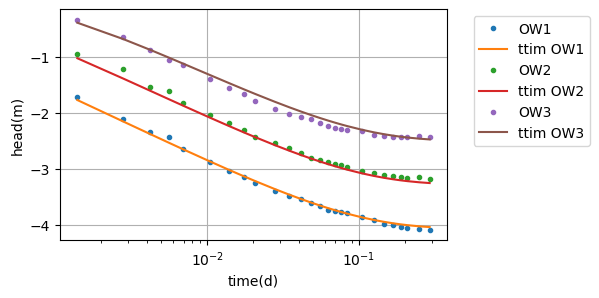

In [8]:
hm1_0 = ml_0.head(r1, 0, t1)
hm2_0 = ml_0.head(r2, 0, t2)
hm3_0 = ml_0.head(r3, 0, t3)
plt.semilogx(t1, h1, ".", label="OW1")
plt.semilogx(t1, hm1_0[0], label="ttim OW1")
plt.semilogx(t2, h2, ".", label="OW2")
plt.semilogx(t2, hm2_0[0], label="ttim OW2")
plt.semilogx(t3, h3, ".", label="OW3")
plt.semilogx(t3, hm3_0[0], label="ttim OW3")
plt.xlabel("time(d)")
plt.ylabel("head(m)")
plt.legend(bbox_to_anchor=(1.05, 1))
plt.grid()

Since the specific storage of the aquitard (```Sll```) is very close to the minimum limit (zero), we will test to set Sll to 0 and remove it from the calibration:

### Model calibration without aquitard storage

In [9]:
ml_1 = ttm.ModelMaq(
    kaq=10,
    z=[0, zt, zb],
    Saq=0.001,
    Sll=0,
    c=10,
    tmin=0.001,
    tmax=1,
    topboundary="semi",
)
w_1 = ttm.Well(ml_1, xw=0, yw=0, rw=rw, tsandQ=[(0, Q)], layers=0)
ml_1.solve()

self.neq  1
solution complete


In [10]:
# unknown parameters: kaq, Saq, c
ca_1 = ttm.Calibrate(ml_1)
ca_1.set_parameter(name="kaq0", initial=10)
ca_1.set_parameter(name="Saq0", initial=1e-4)
ca_1.set_parameter(name="c0", initial=100)
ca_1.series(name="OW1", x=r1, y=0, t=t1, h=h1, layer=0)
ca_1.series(name="OW2", x=r2, y=0, t=t2, h=h2, layer=0)
ca_1.series(name="OW3", x=r3, y=0, t=t3, h=h3, layer=0)
ca_1.fit()

............................................
Fit succeeded.


In [11]:
display(ca_1.parameters.loc[:, ["optimal"]])
print("RMSE:", ca_1.rmse())

,optimal
kaq0,224.633797
Saq0,0.000213
c0,43.882402


RMSE: 0.06024025968001043


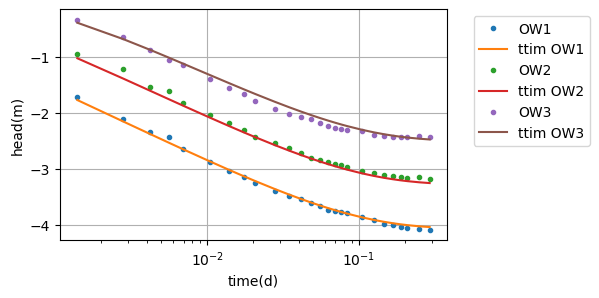

In [12]:
hm1_1 = ml_1.head(r1, 0, t1)
hm2_1 = ml_1.head(r2, 0, t2)
hm3_1 = ml_1.head(r3, 0, t3)
plt.semilogx(t1, h1, ".", label="OW1")
plt.semilogx(t1, hm1_1[0], label="ttim OW1")
plt.semilogx(t2, h2, ".", label="OW2")
plt.semilogx(t2, hm2_1[0], label="ttim OW2")
plt.semilogx(t3, h3, ".", label="OW3")
plt.semilogx(t3, hm3_1[0], label="ttim OW3")
plt.xlabel("time(d)")
plt.ylabel("head(m)")
plt.legend(bbox_to_anchor=(1.05, 1))
plt.grid()

The model with fixed Sll has a similar performance to the former model. The second model has an AIC value of -432.269, two units lower than the former model (-430.268). Thus, Sll should be set to zero (default value) and keep removed from the calibration.

### Summary of values

Here we compare the simulations done with TTim with the one done in AQTESOLV. The values are almost identical.

In [13]:
t = pd.DataFrame(
    columns=["k [m/d]", "Ss [1/m]", "c [d]"],
    index=["AQTESOLV", "ttim"],
)
t.loc["AQTESOLV"] = [224.726, 2.125e-4, 43.964]
t.loc["ttim"] = ca_1.parameters["optimal"].values
t["RMSE"] = [0.059627, ca_1.rmse()]
t

,k [m/d],Ss [1/m],c [d],RMSE
AQTESOLV,224.726,0.000212,43.964,0.059627
ttim,224.633797,0.000213,43.882402,0.060240


## References

* Carlson F, Randall J (2012) MLU: a Windows application for the analysis of aquifer tests and the design of well fields in layered systems. Ground Water 50(4):504–510
* Duffield, G.M., 2007. AQTESOLV for Windows Version 4.5 User's Guide, HydroSOLVE, Inc., Reston, VA.
* Newville, M.,Stensitzki, T., Allen, D.B., Ingargiola, A. (2014) LMFIT: Non Linear Least-Squares Minimization and Curve Fitting for Python.https://dx.doi.org/10.5281/zenodo.11813. https://lmfit.github.io/lmfit-py/intro.html (last access: August,2021).
* Yang, Xinzhu (2020) Application and comparison of different methodsfor aquifer test analysis using TTim. Master Thesis, Delft University of Technology (TUDelft), Delft, The Netherlands.